<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/ChaienrLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing to use chainer

In [2]:
#http://dume.blog77.fc2.com/blog-date-201810.html
!curl https://colab.chainer.org/install | sh - > /dev/null
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0    843      0  0:00:01  0:00:01 --:--:--   843
+ apt -y -q install cuda-libraries-dev-9-2


+ pip install -q cupy-cuda92  chainer 
+ set +ex
Extracting templates from packages: 100%


In [4]:
!mkdir temp
%cd temp
!ls

/content/temp


Download data


In [12]:
!wget https://hce-lab.net/cloud/index.php/s/jCF5ekOtInStnZU/download -O dat.csv

--2018-12-02 07:58:24--  https://hce-lab.net/cloud/index.php/s/jCF5ekOtInStnZU/download
Resolving hce-lab.net (hce-lab.net)... 133.87.177.104
Connecting to hce-lab.net (hce-lab.net)|133.87.177.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2334 (2.3K) [text/csv]
Saving to: ‘dat.csv’

dat.csv             100%[===================>]   2.28K  --.-KB/s    in 0s      

2018-12-02 07:58:25 (228 MB/s) - ‘dat.csv’ saved [2334/2334]



In [0]:
!cat dat.csv

In [0]:
import pandas as pd

df = pd.read_csv('dat.csv')
data = df["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"].values



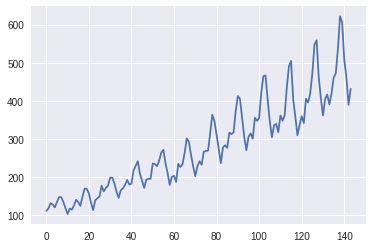

In [30]:
# check dataset
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(data)
plt.show()

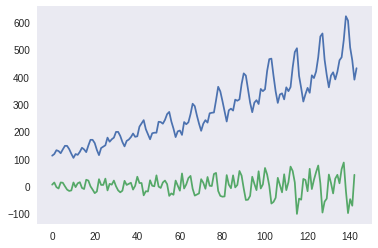

In [32]:
# Make data for leaning
import numpy as np

def difference(series):
    diffed =  series[1:] - series[:-1]
    return diffed

diffed = difference(data)

#plt.figure(figsize=(15,10))
plt.grid()

plt.plot(data)
plt.plot(diffed)
plt.show()

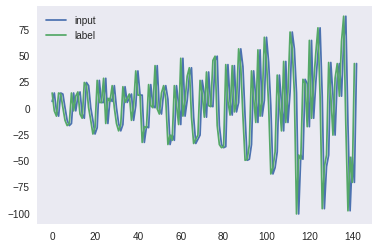

In [54]:
# Make superviser
def supervise(series):
    X = series[:-1]
    y = series[1:]
    return X, y

X, y = supervise(diffed)

#plt.figure(figsize=(15,10))
plt.grid()

plt.plot(X, label='input')
plt.plot(y, label='label')
plt.legend()
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  shuffle=False)

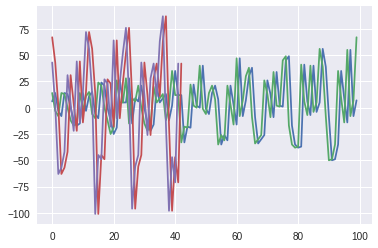

In [40]:
plt.plot(X_train)
plt.plot(y_train)
plt.plot(X_val)
plt.plot(y_val)
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler

def scale(X_train, X_val, y_train, y_val):
    # change type
    X_train = X_train.astype(np.float32)
    X_val   =   X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val   =   y_val.astype(np.float32)

    # scale inputs
    sclr = MinMaxScaler()
    X_train = sclr.fit_transform(X_train)
    X_val   = sclr.transform(X_val)

    # scale labels
    ysclr = MinMaxScaler()
    y_train = ysclr.fit_transform(y_train)
    y_val   = ysclr.transform(y_val)

    return X_train, X_val, y_train, y_val, sclr, ysclr

In [0]:
from chainer import Chain
import chainer.links as L

class RNN(Chain):
    def __init__(self, units):
        """
        units (tuple): e.g. (4, 5, 3)
            - 1層目のLSTM: 4つのneuron
            - 2層目のLSTM: 5つのneuron
            - 3層目のLSTM: 3つのneuron
        """
        super(RNN, self).__init__()

        n_in  = 1 # features
        n_out= 1

        lstms = [('lstm{}'.format(l), L.LSTM(None, n_unit))
                for l, n_unit in enumerate(units)]
        self.lstms = lstms
        for name, lstm in lstms:
            self.add_link(name, lstm)

        self.add_link('fc', L.Linear(units[-1], n_out))


    def __call__(self, x):
        """
        # Param
        - x (Variable: (S, F))
        S: samples
        F: features

        # Return
        -   (Variable: (S, 1))
        """
        h = x
        for name, lstm in self.lstms:
            h = lstm(h)
        return self.fc(h)

    def reset_state(self):
        for name, lstm in self.lstms:
            lstm.reset_state()

In [0]:
import chainer.links as L
import chainer.functions as F

class LossSumMSEOverTime(L.Classifier):
    def __init__(self, predictor):
        super(LossSumMSEOverTime, self).__init__(predictor, lossfun=F.mean_squared_error)

    def __call__(self, X_STF, y_STF):
        """
        # Param
        - X_STF (Variable: (S, T, F))
        - y_STF (Variable: (S, T, F))
        S: samples
        T: time_steps
        F: features

        # Return
        - loss (Variable: (1, ))
        """
        # 時間 T で loop させるため、Tを先頭の軸にする
        X_TSF = X_STF.transpose(1,0,2)
        y_TSF = y_STF.transpose(1,0,2)
        seq_len  = X_TSF.shape[0]

        # 各時刻についてlossをとり、最終的なlossに足していく
        loss = 0
        for t in range(seq_len):
            pred = self.predictor(X_TSF[t])
            obs  = y_TSF[t]
            loss += self.lossfun(pred, obs)
        # loss の大きさが時系列長に依存してしまうので、時系列長で割る
        loss /= seq_len

        # reporter に loss の値を渡す
        reporter.report({'loss': loss}, self)

        return loss

In [0]:
from chainer import training
from chainer import Variable, reporter

class UpdaterRNN(training.StandardUpdater):
    def __init__(self, itr_train, optimizer, device=-1):
        super(UpdaterRNN, self).__init__(itr_train, optimizer, device=device)

    # overrided
    def update_core(self):
        itr_train = self.get_iterator('main')
        optimizer = self.get_optimizer('main')

        batch = itr_train.__next__()
        X_STF, y_STF = chainer.dataset.concat_examples(batch, self.device)

        optimizer.target.zerograds()
        optimizer.target.predictor.reset_state()
        loss = optimizer.target(Variable(X_STF), Variable(y_STF))

        loss.backward()
        optimizer.update()

In [60]:
import chainer
from chainer.optimizers import RMSprop
from chainer.iterators import SerialIterator
from chainer.training import extensions

# model
units = (5, 4, 3)
model = LossSumMSEOverTime(RNN(units))

# optimizer
optimizer = RMSprop()
optimizer.setup(model)

# dataset (Datasetオブジェクトじゃなくて、list(zip())でも可)
#df = pd.read_csv('international-airline-passengers.csv')
df = pd.read_csv('dat.csv')
#1ではなく1:とするのは、shapeを(144,)ではなく(144,1)とするため
series = df.iloc[:,1:].values 
#series = series[~np.isnan(series)] # remove Nan
diffed = difference(series)
X, y = supervise(diffed)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  shuffle=False)

y_val[np.isnan(y_val)] = 0
X_train, X_val, y_train, y_val, sclr, ysclr = scale(X_train, X_val, y_train, y_val)
# change type
X_train = X_train.astype(np.float32)
X_val   =   X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val   =   y_val.astype(np.float32)
# change shape
X_train = X_train[np.newaxis, :, :]
X_val   =   X_val[np.newaxis, :, :]
y_train = y_train[np.newaxis, :, :]
y_val   =   y_val[np.newaxis, :, :]
ds_train = list(zip(X_train, y_train))
ds_val   = list(zip(X_val  , y_val  ))

# iterator
itr_train = SerialIterator(ds_train, batch_size=1, shuffle=False)
itr_val   = SerialIterator(ds_val  , batch_size=1, shuffle=False, repeat=False)

# updater
updater = UpdaterRNN(itr_train, optimizer)

# trainer
trainer = training.Trainer(updater, (1000, 'epoch'), out='results')
# evaluation
eval_model = model.copy()
eval_rnn = eval_model.predictor
trainer.extend(extensions.Evaluator(
            itr_val, eval_model, device=-1,
            eval_hook=lambda _: eval_rnn.reset_state()))
# other extensions
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot_object(model.predictor, 
                                           filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.PrintReport(
                ['epoch','main/loss','validation/main/loss']
            ))

trainer.run()

epoch       main/loss   validation/main/loss
1           0.273325    0.244354              
2           0.125373    0.1766                
3           0.0462909   0.189054              
4           0.0621899   0.182546              
5           0.0527381   0.181952              
6           0.0533766   0.174745              
7           0.0441136   0.174667              
8           0.0440794   0.174654              
9           0.0440503   0.174616              
10          0.0440223   0.174589              
11          0.043995    0.174559              
12          0.0439681   0.17453               
13          0.0439416   0.174501              
14          0.0439154   0.174472              
15          0.0438895   0.174443              
16          0.043864    0.174414              
17          0.0438387   0.174385              
18          0.0438137   0.174356              
19          0.0437889   0.174327              
20          0.0437643   0.174298              
21          0.0

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


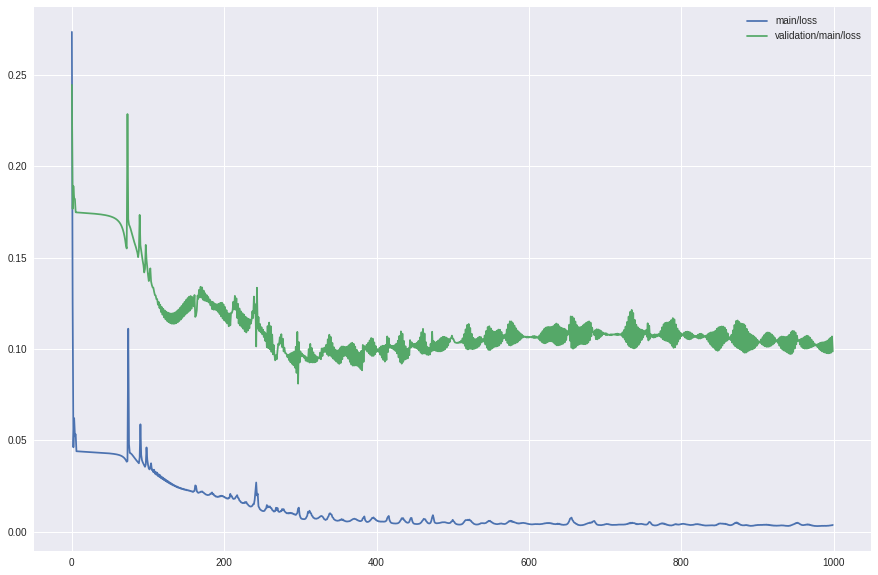

In [61]:
log = pd.read_json('results/log')
log.plot(y=['main/loss', 'validation/main/loss'],
         figsize=(15,10),
         grid=True)

In [62]:
import os
from chainer import serializers

best_idx = log['validation/main/loss'].argmin()
best_epoch = int(log['epoch'].ix[best_idx])

units = (5, 4, 3)
model = RNN(units)
weight_file = os.path.join('results', 'model_epoch-{}'.format(best_epoch))
serializers.load_npz(weight_file, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


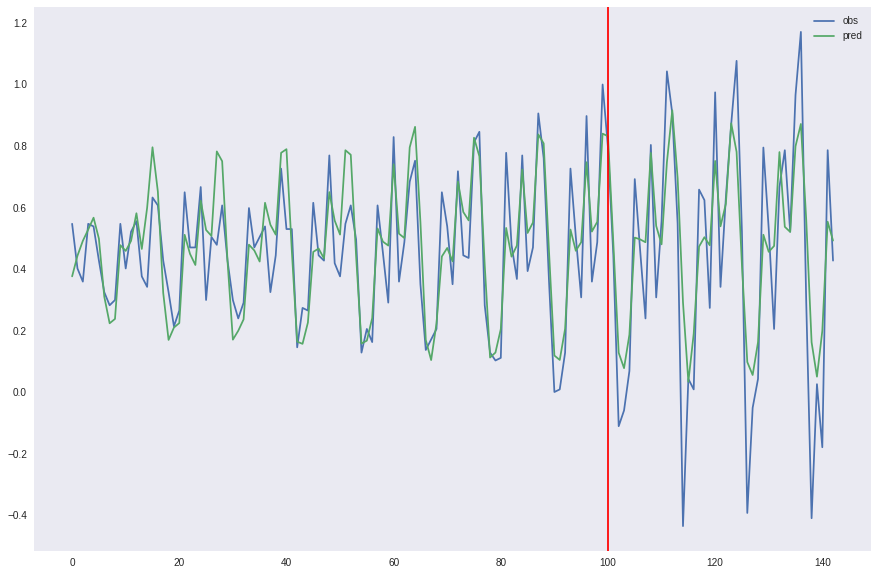

In [63]:
model.reset_state()

n_train = X_train.shape[1]
n_val = X_val.shape[1]

X = np.concatenate((X_train, X_val), axis=1)[0]
obs = np.concatenate((y_train, y_val), axis=1)[0]

# prediction
pred = []
for X_t in X:
    p_t = model(X_t.reshape(-1,1)).data[0]
    pred.append(p_t)

plt.figure(figsize=(15,10))

plt.plot(obs, label='obs')
plt.plot(pred, label='pred')

plt.grid()
plt.legend()
plt.axvline(n_train, color='r')

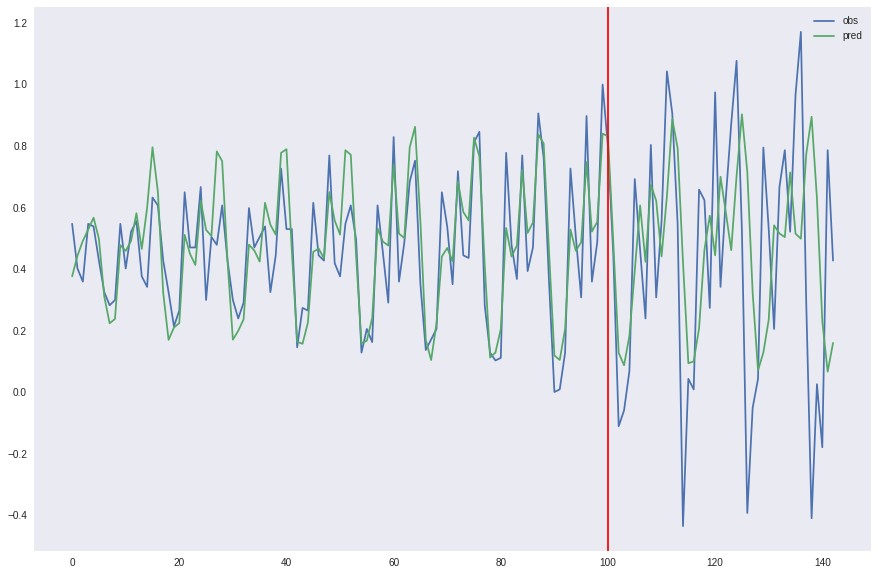

In [64]:
model.reset_state()

# train data に関しては先ほどと同じく、観測値を使って予測し、
# 隠れ層の状態を作る。
pred = []
for X_t in X_train[0]:
    p_t = model(X_t.reshape(-1,1)).data[0]
    pred.append(p_t)

# valdiation data に対する予測
p_t = X_val[0,0]
n_pred = n_val
for t in range(n_pred):
    p_t = model(p_t.reshape(-1,1)).data[0]
    pred.append(p_t)

plt.figure(figsize=(15,10))

plt.plot(obs, label='obs')
plt.plot(pred, label='pred')

plt.grid()
plt.legend()
plt.axvline(n_train, color='r')

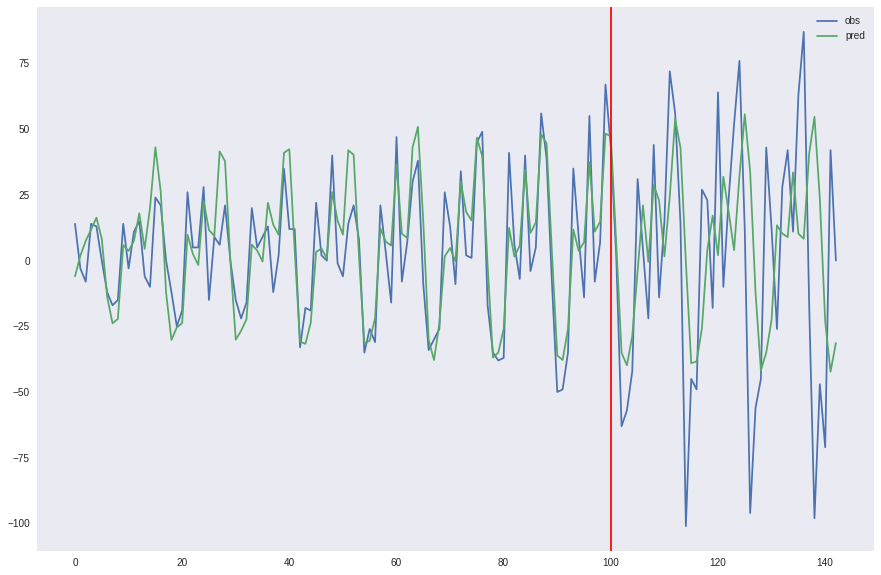

In [65]:
obs_unscale = ysclr.inverse_transform(obs)
pred_unscale = ysclr.inverse_transform(pred)

plt.figure(figsize=(15,10))

plt.plot(obs_unscale, label='obs')
plt.plot(pred_unscale, label='pred')

plt.grid()
plt.legend()
plt.axvline(n_train, color='r')

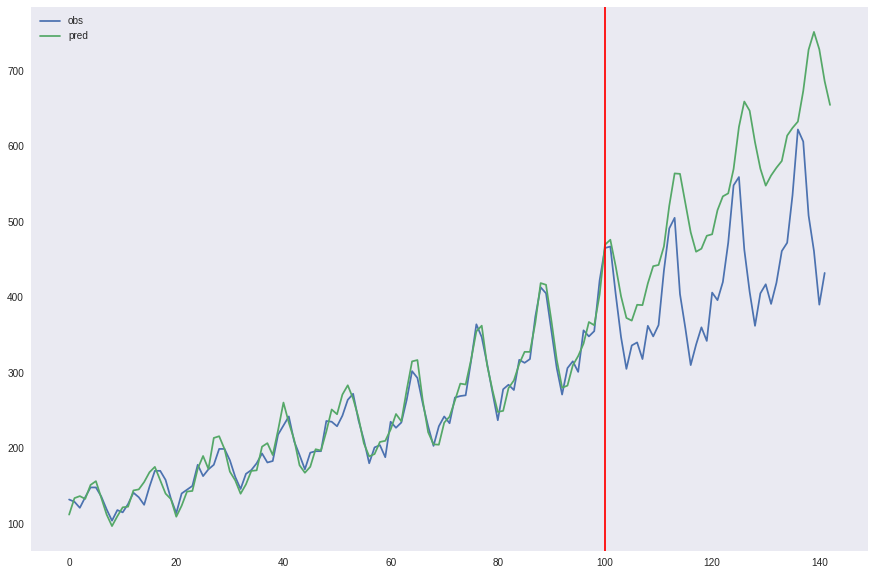

In [66]:
obs_undiff = series[2:]

pred_train = pred_unscale[:n_train] + series[1:1+n_train]

pred_val = []
X_t = series[n_train+1]
for D_t in pred_unscale[n_train:]:
    X_t = D_t + X_t
    pred_val.append(X_t)
pred_undiff = np.concatenate((pred_train,
                              pred_val), axis=0)

plt.figure(figsize=(15,10))

plt.plot(obs_undiff, label='obs')
plt.plot(pred_undiff, label='pred')

plt.grid()
plt.legend()
plt.axvline(n_train, color='r')